In [1]:
from emle.models import EMLE
from emle_bespoke.patching import EMLEPatched
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl
import torch
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from math import sqrt

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:116: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\m'
<>:153: SyntaxWarning: invalid escape sequence '\m'
<>:154: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:116: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\m'
<>:153: SyntaxWarning: invalid escape sequence '\m'
<>:154: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2640320/396701429.py:115: SyntaxWarning: invalid escape sequence '\m'
  axes[idx, 0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_2640320/396701429.py:116: SyntaxWarning: invalid escape sequence '\m'
  axes[idx, 0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_2640320/396701429.py:132: SyntaxWarning: invalid escape sequ

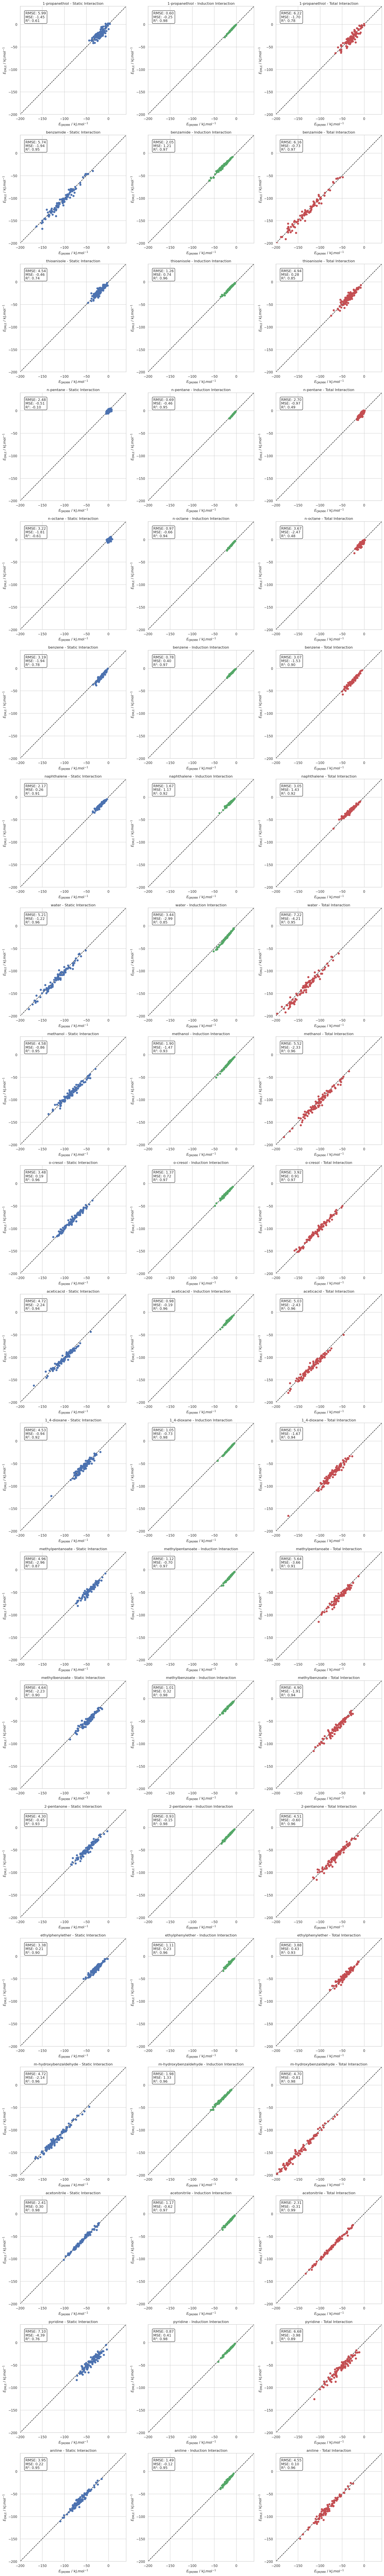

                      mol      rmse       mse
0          1-propanethiol  6.223618 -1.703336
1               benzamide  6.157709 -0.734287
2             thioanisole  4.936954  0.283986
3               n-pentane  2.698134 -0.969441
4                n-octane  3.670867 -2.470904
5                 benzene  3.067568 -1.533754
6             naphthalene  3.051723  1.433622
7                   water  7.224740 -4.208487
8                methanol  5.521846 -2.332377
9                o-cresol  3.920961  0.912404
10             aceticacid  5.033052 -2.425845
11            1_4-dioxane  5.014894 -1.674373
12       methylpentanoate  5.637248 -3.662749
13         methylbenzoate  4.897077 -1.907683
14            2-pentanone  4.511772 -0.604126
15       ethylphenylether  3.876742  0.433809
16  m-hydroxybenzaldehyde  4.701885 -0.809705
17           acetonitrile  2.314422 -0.312461
18               pyridine  6.683691 -3.979134
19                aniline  4.551537  0.101118


In [2]:
sns.set(style="whitegrid")

mols = [
    "1-propanethiol",
    "benzamide",
    "thioanisole",
    "n-pentane",
    "n-octane",
    "benzene",
    "naphthalene",
    "water",
    "methanol",
    "o-cresol",
    "aceticacid",
    "1_4-dioxane",
    "methylpentanoate",
    "methylbenzoate",
    "2-pentanone",
    "ethylphenylether",
    "m-hydroxybenzaldehyde",
    "acetonitrile",
    "pyridine",
    "aniline",
]

# Create the figure and axes for the subplots
num_mols = len(mols)
fig, axes = plt.subplots(num_mols, 3, figsize=(18, 6 * num_mols))

# Ensure axes is always a 2D array
axes = np.atleast_2d(axes)

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x

# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(predicted_values - true_values)
    rmse = np.sqrt(np.mean((predicted_values - true_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2

use_bespoke = True

# Loop through each molecule
pre = "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training2/sampling"
rmse_list = []
mse_list = []
for idx, mol in enumerate(mols):
    with open(
        f"{pre}/{mol}/{mol}_ref_data.pkl",
        "rb",
    ) as f:
        data = pkl.load(f)

    # Load the MBIS data
    alpha_mode = "species"
    model = f"/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training/ligand_bespoke_patched_{alpha_mode}.mat"
    bespoke_model = (
        model
        if use_bespoke
        else None
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float64
    alpha_static = 1.0
    beta_induced = 1.0
    emle_model = EMLEPatched(
        device=device,
        dtype=dtype,
        model=bespoke_model,
        alpha_static=alpha_static,
        beta_induced=beta_induced,
        method="electrostatic",
        alpha_mode=alpha_mode,
    )

    # Calculate the predicted static and induction energies
    from emle.train._utils import pad_to_max

    z = pad_to_max(data["z"]).to(device=device, dtype=torch.int64)
    charges_mm = pad_to_max(data["charges_mm"]).to(device=device, dtype=dtype)
    xyz_qm = pad_to_max(data["xyz_qm"]).to(device=device, dtype=dtype)
    xyz_mm = pad_to_max(data["xyz_mm"]).to(device=device, dtype=dtype)
    e_static_emle, e_ind_emle = emle_model.forward(z, charges_mm, xyz_qm, xyz_mm)

    e_static_emle = e_static_emle * HARTREE_TO_KJ_MOL
    e_ind_emle = e_ind_emle * HARTREE_TO_KJ_MOL

    # Example data (replace with your actual data)
    e_static = np.array([x.item() for x in data["e_static"]])
    e_ind = np.array([x.item() for x in data["e_ind"]])
    e_static_emle = np.array([x.item() for x in e_static_emle])
    e_ind_emle = np.array([x.item() for x in e_ind_emle])

    energy_scaling = 1
    e_static *= energy_scaling
    e_ind *= energy_scaling
    e_static_emle *= energy_scaling
    e_ind_emle *= energy_scaling

    # Set limits for all subplots and plot reference line
    xmin, xmax = -200, 40
    ymin, ymax = -200, 40
    for ax in axes[idx]:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.plot(x, y, "k--", label="Reference Line")

    # Static subplot
    rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
    axes[idx, 0].plot(e_static, e_static_emle, "bo", label="Static")
    axes[idx, 0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
    axes[idx, 0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
    axes[idx, 0].set_title(f"{mol} - Static Interaction")
    axes[idx, 0].text(
        0.05,
        0.95,
        f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
        transform=axes[idx, 0].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )

    # Induction subplot
    rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind, e_ind_emle)
    axes[idx, 1].plot(e_ind, e_ind_emle, "go", label="Induction")
    axes[idx, 1].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
    axes[idx, 1].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
    axes[idx, 1].set_title(f"{mol} - Induction Interaction")
    axes[idx, 1].text(
        0.05,
        0.95,
        f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
        transform=axes[idx, 1].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )

    # Total subplot
    rmse_total, mse_total, r2_total = compute_metrics(
        e_static + e_ind, e_static_emle + e_ind_emle
    )
    rmse_list.append(rmse_total)
    mse_list.append(mse_total)
    axes[idx, 2].plot(e_static + e_ind, e_static_emle + e_ind_emle, "ro", label="Total")
    axes[idx, 2].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
    axes[idx, 2].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
    axes[idx, 2].set_title(f"{mol} - Total Interaction")
    axes[idx, 2].text(
        0.05,
        0.95,
        f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
        transform=axes[idx, 2].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# df with mol, rmse, mse
import pandas as pd
df = pd.DataFrame({"mol": mols, "rmse": rmse_list, "mse": mse_list})
print(df)

it=1
df.to_csv(f"data/general_{alpha_mode}_{it}.csv", index=False)
